### Re-implementation of "Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning"

Image-based deep learning classifies macular degeneration and diabetic retinopathy using retinal optical coherence tomography (OCT) images and has potential for generalized applications in biomedical image interpretation and medical decision making. Kermany et al., 2018, Cell 172, 1122–1131 February 22, 2018 2018 Elsevier Inc. https://doi.org/10.1016/j.cell.2018.02.010

The paper uses transfer learning, with an InceptionV3 model pre-trained on the ImageNet dataset. 


In [62]:
import os
import time
import numpy as np
import PIL
import PIL.Image

import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Input, Dense, Flatten, Rescaling
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
PATH_TO_DATASET = "../../../../../../research/datasets/ZhangLabData/CellData/OCT"
PATH_TO_TRAIN_DATASET = os.path.join(PATH_TO_DATASET, "train")
PATH_TO_TEST_DATASET = os.path.join(PATH_TO_DATASET, "test")

In [3]:
batch_size = 100
epochs = 100

# Max image size for InceptionV3
img_height = 299
img_width = 299

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    PATH_TO_TRAIN_DATASET,
    label_mode="categorical",
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    PATH_TO_TEST_DATASET,
    label_mode="categorical",
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

class_names = train_ds.class_names
num_classes = len(class_names)

Found 108309 files belonging to 4 classes.
Found 1000 files belonging to 4 classes.


#### TODO: 
Authors recode the data to have 3 classes instead of 4:
 - CNV & DMR -> urgent referrals
 - Drusen -> routine referrals
 - Normal -> normal

In [5]:
def build_classifier():
    # InceptionV3 pretrained on ImageNet
    base_model = InceptionV3(
        include_top=False,
        weights="imagenet",
        input_shape=(img_height, img_width, 3),
        pooling="avg",
    )
    # Freeze parameters
    base_model.trainable = False

    # Model definition
    input_data = Input(shape=(img_height, img_width, 3))
    # InceptionV3 expects pixel data in range [-1,1]
    x = Rescaling(1.0 / 127.5, offset=-1)(input_data)
    x = base_model(x, training=False)
    output = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=input_data, outputs=output)

    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

In [6]:
classifier = build_classifier()
classifier.summary()

# Train network until convergence
early_stopping = EarlyStopping(monitor="loss", patience=3)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-5)
r = classifier.fit(
    train_ds,
    epochs=epochs,
    validation_data=test_ds,
    verbose=1,
    callbacks=[early_stopping, reduce_lr],
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 299, 299, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 4)                 8196      
                                                                 
Total params: 21,810,980
Trainable params: 8,196
Non-trainable params: 21,802,784
_________________________________________________________________
Epoch 1/100
1084/1084 [==============================] - 223s 201ms/step - loss: 0.3965 - accuracy: 0.8626 - val_loss: 0.3239 - val_accuracy: 0.8820 - lr: 0.0010
Epoch 2/100
108

1084/1084 [==============================] - 220s 203ms/step - loss: 0.2091 - accuracy: 0.9275 - val_loss: 0.2049 - val_accuracy: 0.9260 - lr: 0.0010
Epoch 46/100
1084/1084 [==============================] - 221s 203ms/step - loss: 0.2088 - accuracy: 0.9278 - val_loss: 0.2255 - val_accuracy: 0.9170 - lr: 0.0010


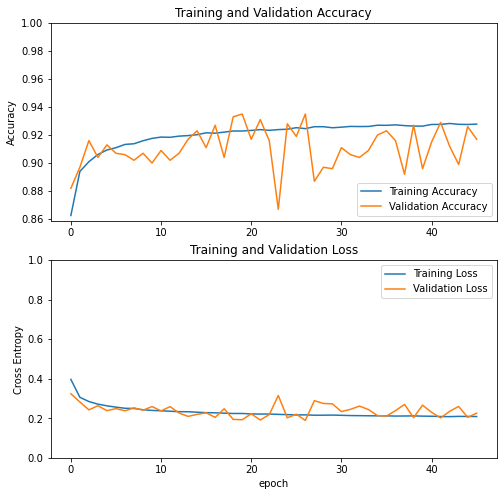

In [7]:
acc = r.history["accuracy"]
val_acc = r.history["val_accuracy"]

loss = r.history["loss"]
val_loss = r.history["val_loss"]

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.ylabel("Accuracy")
plt.ylim([min(plt.ylim()), 1])
plt.title("Training and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.ylabel("Cross Entropy")
plt.ylim([0, 1.0])
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()

In [69]:
y_pred = np.array([])
y_true = np.array([])
for x, y in test_ds:
    y_true = np.concatenate((y_true, np.argmax(y, axis=1)), axis=0)
    y_pred = np.concatenate((y_pred, np.argmax(classifier.predict(x), axis=1)), axis=0)

In [70]:
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

         CNV     0.8294    0.9720    0.8950       250
         DME     0.9373    0.9560    0.9465       250
      DRUSEN     0.9847    0.7720    0.8655       250
      NORMAL     0.9453    0.9680    0.9565       250

    accuracy                         0.9170      1000
   macro avg     0.9242    0.9170    0.9159      1000
weighted avg     0.9242    0.9170    0.9159      1000



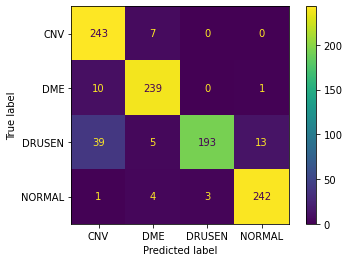

In [71]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.show()

In [10]:
from datetime import datetime

classifier.save("OCT-Kermany-" + datetime.now().strftime("%Y%m%d-%H.%M"))

INFO:tensorflow:Assets written to: OCT-Kermany-20220111-21.38\assets


In [ ]:
# To retrieve saved model
# model = keras.models.load_model('OCT-Kermany-model')